# CarND-Vehicle-Detection
---
This is the last project for the ** Udacity Self Driven Car Nano Degree** Term 1.The code for the project is divided into Exploration and Execution phases

---
The goals for this project as set by the Udacity team are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Exploration

**Imports**

In [1]:
import random
import os
import cv2
import glob
import time
import pickle
import collections
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

** Loading images **

In [2]:
vehicles_imgs = glob.glob('./images/vehicles/**/*.png', recursive=True)
non_vehicles_imgs = glob.glob('./images/non-vehicles/**/*.png', recursive=True)

print('Vehicles:', len(vehicles_imgs))
print('Non-Vehicles:', len(non_vehicles_imgs))

Vehicles: 8792
Non-Vehicles: 8968


** Display images Function **

In [3]:
def display_images(rows, cols, imgs, titles=None, cmap='hot', axis='off', figsize=(16, 12)):
    """
    Display images in an array of the form (rows X cols)

    :param rows: Number of rows in the
    :param cols: Number of columns in the
    :param imgs: Images to be displayed
    :param titles: Title to be appended to images top (Default: None)
    :param cmap: Matplotlib color map
    :param axis: Boolean to turn on or off the plot axis grid
    :param figsize: Images display size
    :return: None - Only display the images
    """

    plt.figure(figsize=figsize)   
    for index, img in enumerate(imgs):
        plt.subplot(rows, cols, index + 1)
        plt.axis(axis)
        if titles: plt.title(titles[index])
        # If the image is in color then show else use cmap and show
        if len(img.shape) == 3:
            plt.imshow(img)            
        else:
            plt.imshow(img, cmap=cmap)
    plt.show()
    plt.close('all')  # Closing all images

** Displaying images of Vehicles**

Images of Vehicles


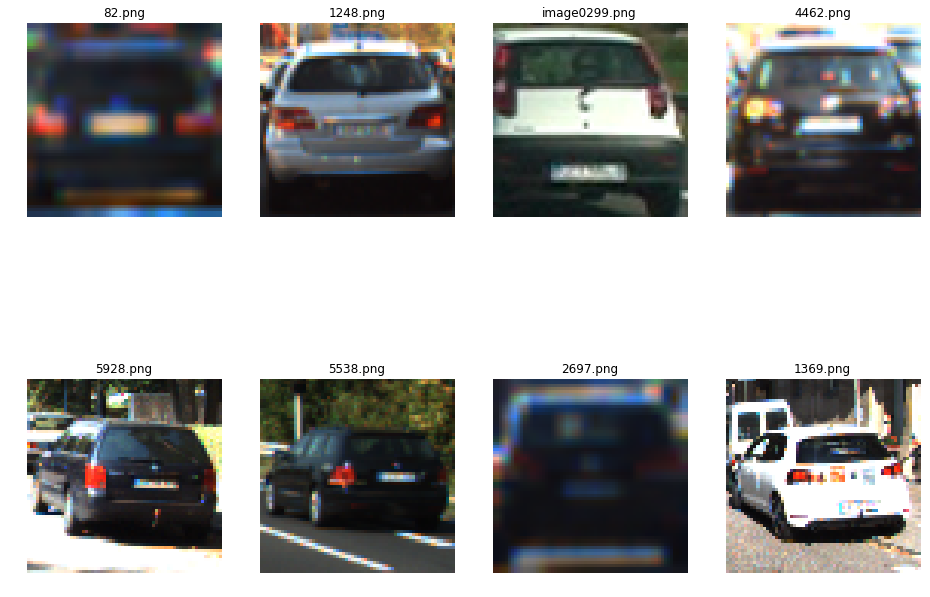

In [4]:
NUM_IMGS = 8    # Number of images to sample

vehicles_img = []
vehicles_titles = []
for index in random.sample(range(len(vehicles_imgs)), NUM_IMGS):
    vehicles_img.append(cv2.cvtColor(cv2.imread(vehicles_imgs[index]), cv2.COLOR_BGR2RGB))
    vehicles_titles.append(os.path.basename(vehicles_imgs[index]))

print('Images of Vehicles')
print('==================')
display_images(2, NUM_IMGS/2, vehicles_img, vehicles_titles)

** Displaying image of Non-Vehicles**

Images of Non-Vehicles


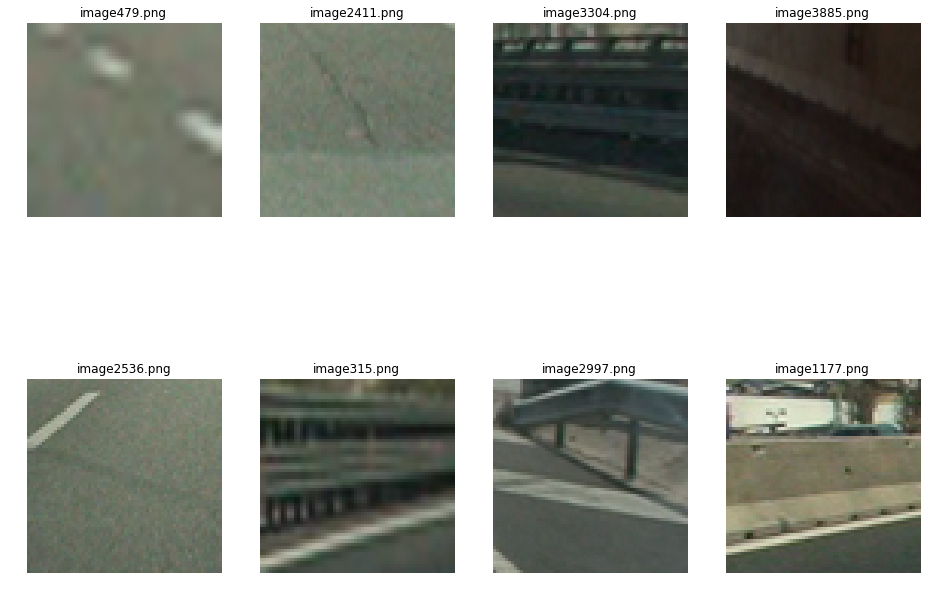

In [5]:
non_vehicles_img = []
non_vehicles_titles = []
for index in random.sample(range(len(non_vehicles_imgs)), NUM_IMGS):
    non_vehicles_img.append(cv2.cvtColor(cv2.imread(non_vehicles_imgs[index]), cv2.COLOR_BGR2RGB))
    non_vehicles_titles.append(os.path.basename(non_vehicles_imgs[index]))

print('Images of Non-Vehicles')
print('======================')
display_images(2, NUM_IMGS/2, non_vehicles_img, non_vehicles_titles)

** Displaying Histogram of Oriented Gradients (HOG)**

In [6]:
def sampling_hog(files, num_samples):
    """
    Perform Histogram of Oriented Gradients (HOG) to the given images

    :param files: list of files, path
    :param num_samples: Number of sample images
    :return: Original images with its HOG and respective HOG channel title
    """
    images = []
    titels = []

    random_indexes = random.sample(range(len(files)), num_samples)

    for index in random_indexes:
        image = cv2.imread(files[index])
        ycrcb_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        _, hog_img_0 = hog(ycrcb_img[:, :, 0], 9, (8, 8), (2, 2), visualise=True)
        _, hog_img_1 = hog(ycrcb_img[:, :, 1], 9, (8, 8), (2, 2), visualise=True)
        _, hog_img_2 = hog(ycrcb_img[:, :, 2], 9, (8, 8), (2, 2), visualise=True)
        titels.extend(['Original', 'HOG Y-channel', 'HOG Cr-channel', 'HOG Cb-channel'])
        images.extend([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), hog_img_0, hog_img_1, hog_img_2])

    return images, titels

** Displaying HOG of Vehicles **

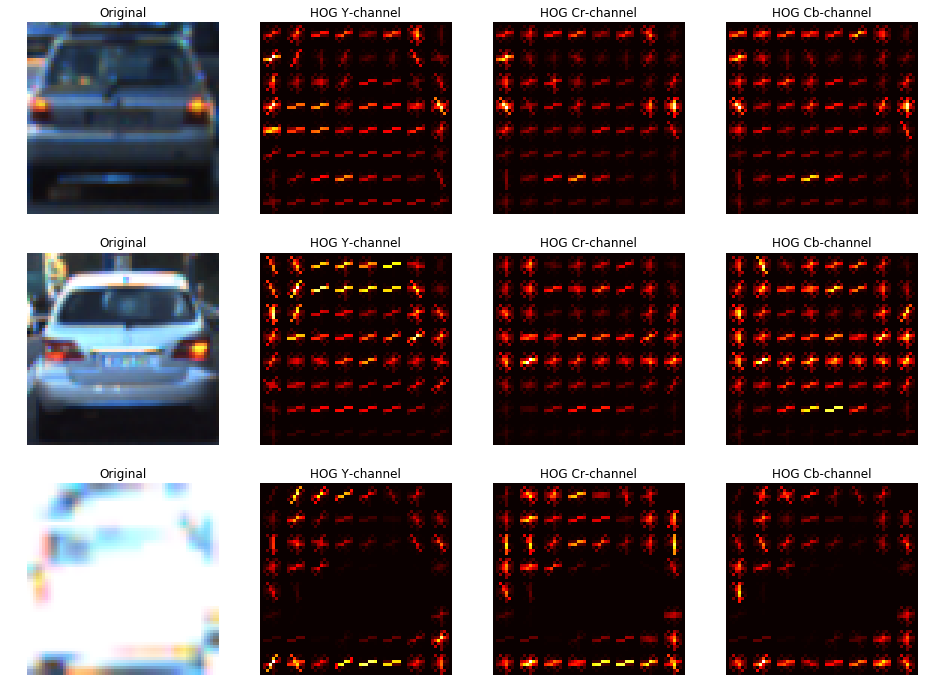

In [7]:
NUM_IMGS = 3
images, titels = sampling_hog(vehicles_imgs, NUM_IMGS)
display_images(NUM_IMGS, 4, images, titels)

** Displaying HOG of Non-Vehicles **

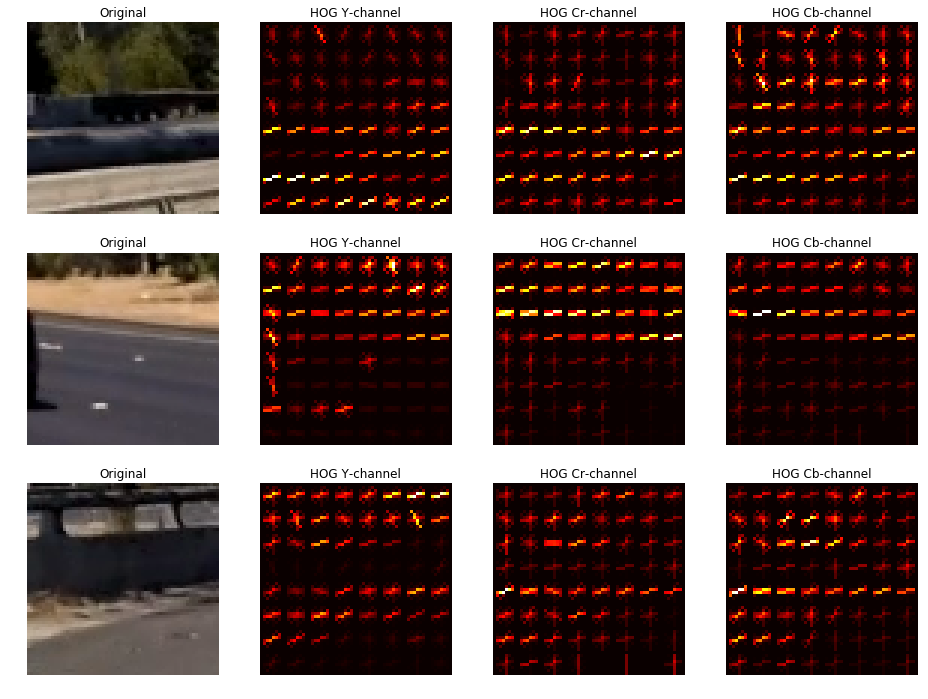

In [8]:
NUM_IMGS = 3
images, titels = sampling_hog(non_vehicles_imgs, NUM_IMGS)
display_images(NUM_IMGS, 4, images, titels)

### Searching for Features
---

** Helper functions**

In [9]:
def convert_color(img, color='BGR'):
    """
    Convert image color space

    :param img: image to be converted
    :param color: color space to convert to
    :return: a copy image converted to the given parameter color space
    """
    if color == 'BGR':
        return np.copy(img)
    elif color == 'RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif color == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)


def get_img_features(img, features, debug=False):
    """
    Obtained the specify image features 
    
    :param img: Input image to process
    :param features: parameter listing the features to run 
    :param DEBUG: Flag to print out debugging information
    :return: a vector with the calculated features
    """
    feature_vec = []

    # Convert color space as needed
    img_color = convert_color(img, features[1])

    # Resulting features list
    space_feature = []
    color_histogram = []
    hog_features = []

    # Spatial features
    if features[0][0]:
        img_resized = cv2.resize(img_color, features[2])
        for index in range(0, 3):
            space_feature.append(img_resized[:, :, index].ravel())
        feature_vec = np.concatenate((feature_vec, space_feature[0], space_feature[1], space_feature[2]))

    # Color histogram features
    if features[0][1]:
        for index in range(0, 3):
            color_histogram.append(np.histogram(img_color[:, :, index], bins=features[3])[0])
        feature_vec = np.concatenate((feature_vec, color_histogram[0], color_histogram[1], color_histogram[2]))

    # Get hog features
    if features[0][2]:
        for index in range(0, 3):
            hog_features.append(hog(img_color[:, :, index], features[4], features[5], features[6]))
        feature_vec = np.concatenate((feature_vec, hog_features[0], hog_features[1], hog_features[2]))
        
    # Print information for debugging    
    if debug:
        print('Spatial feature length:', len(space_feature))
        print('Color histogram feature length:', len(color_histogram))
        print('Hog feature length:', len(hog_features))
    return feature_vec


def train_classifier(vehicle_features, non_vehicle_features, detailed_svc=False):
    """
    Traing the classifier given two sets
    :param vehicle_features:
    :param non_vehicle_features:
    :param detailed_svc: Flag used to output the Accuracy, SVC, and Scale
    :return: Accuracy by default or Accuracy, SVC, and Scale by changing 'detailed_svc' to True
    """
    X = np.vstack((vehicle_features, non_vehicle_features))
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=rand_state)
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    acc = svc.score(X_test, y_test)
    if detailed_svc:
        return acc, svc, scaler
    else:
        return acc

def get_features(filenames, features):
    """
    
    :param filenames: file list to be processed
    :param features: features to used in the process
    :return: calculated feature vector
    """
    feature_vec = []
    for f in filenames:
        img = cv2.imread(f)
        feature_vec.append(get_img_features(img, features))
    return feature_vec

def print_header():
    """
    Print a heading for the output
    """
    header = ('Id', 'Color', 'Spatial', 'Bins', 'Orient', 'Pixels/Cell',
              'Cells/Block', 'Feature Size', 'Training Time', 'Accuracy')
    print('|' + '|'.join(header) + '|')
    print(''.join(['|:---:'] * len(header)) + '|')


def print_line(id_count, feature_set, size, time, acc):
    """
    Print the out results
    """
    line = []
    line.append(str(id_count))
    line.append(feature_set[1])
    line.append(str(feature_set[2]) if feature_set[0][0] == 1 else 'None')
    line.append(str(feature_set[3]) if feature_set[0][1] == 1 else 'None')
    line.append(str(feature_set[4]) if feature_set[0][2] == 1 else 'None')
    line.append(str(feature_set[5]) if feature_set[0][2] == 1 else 'None')
    line.append(str(feature_set[6]) if feature_set[0][2] == 1 else 'None')
    line.extend((str(size), str(round(time, 2)) + 's', str(round(acc * 100, 2)) + '%'))
    print('|' + '|'.join(line) + '|')

In [10]:
# ((spatial, color, hog), color, spatial_size, color_bins, orient, pixels_per_cell, cells_per_block)
# In (spatial, color, hog) a value of 1 turn on the feature and 0 off
feature_sets = [[(0, 0, 1), 'RGB', (32,32), 32, 5, (8,8), (2,2)], 
                [(0, 0, 1), 'RGB', (32,32), 32, 7, (8,8), (2,2)], 
                [(1, 1, 1), 'RGB', (32,32), 32, 9, (8,8), (2,2)], 
                [(1, 1, 1), 'HLS', (32,32), 32, 9, (8,8), (2,2)], 
                [(1, 1, 1), 'YUV', (32,32), 32, 9, (8,8), (2,2)], 
                [(0, 0, 1), 'YCrCb', (16,16), 16, 5, (8,8), (2,2)],
                [(0, 0, 1), 'YCrCb', (32,32), 32, 7, (8,8), (2,2)],
                [(0, 0, 1), 'YCrCb', (32,32), 32, 9, (8,8), (2,2)],
                [(1, 1, 1), 'YCrCb', (16,16), 16, 9, (8,8), (2,2)],
                [(1, 1, 1), 'YCrCb', (32,32), 32, 9, (8,8), (2,2)],
                [(1, 1, 1), 'YCrCb', (64,64), 32, 9, (8,8), (2,2)],
               ]

print_header()

for i, feature_set in enumerate(feature_sets):
    t = time.time() # Gets the starting time
    vehicle_features = get_features(vehicles_imgs, feature_set)
    non_vehicle_features = get_features(non_vehicles_imgs, feature_set)
    acc = train_classifier(vehicle_features, non_vehicle_features)   
    print_line(i + 1, feature_set, len(vehicle_features[0]), time.time() - t, acc)

|Id|Color|Spatial|Bins|Orient|Pixels/Cell|Cells/Block|Feature Size|Training Time|Accuracy|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1|RGB|None|None|5|(8, 8)|(2, 2)|2940|80.76s|95.65%|
|2|RGB|None|None|7|(8, 8)|(2, 2)|4116|124.86s|96.36%|
|3|RGB|(32, 32)|32|9|(8, 8)|(2, 2)|8460|215.5s|98.69%|
|4|HLS|(32, 32)|32|9|(8, 8)|(2, 2)|8460|180.51s|99.32%|
|5|YUV|(32, 32)|32|9|(8, 8)|(2, 2)|8460|172.4s|99.21%|
|6|YCrCb|None|None|5|(8, 8)|(2, 2)|2940|73.3s|98.35%|
|7|YCrCb|None|None|7|(8, 8)|(2, 2)|4116|98.15s|98.27%|
|8|YCrCb|None|None|9|(8, 8)|(2, 2)|5292|123.32s|98.72%|
|9|YCrCb|(16, 16)|16|9|(8, 8)|(2, 2)|6108|162.61s|99.32%|
|10|YCrCb|(32, 32)|32|9|(8, 8)|(2, 2)|8460|165.73s|99.25%|
|11|YCrCb|(64, 64)|32|9|(8, 8)|(2, 2)|17676|204.76s|99.32%|


|Id|Color|Spatial|Bins|Orient|Pixels/Cell|Cells/Block|Feature Size|Training Time|Accuracy|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1|RGB|None|None|5|(8, 8)|(2, 2)|2940|80.76s|95.65%|
|2|RGB|None|None|7|(8, 8)|(2, 2)|4116|124.86s|96.36%|
|3|RGB|(32, 32)|32|9|(8, 8)|(2, 2)|8460|215.5s|98.69%|
|4|HLS|(32, 32)|32|9|(8, 8)|(2, 2)|8460|180.51s|99.32%|
|5|YUV|(32, 32)|32|9|(8, 8)|(2, 2)|8460|172.4s|99.21%|
|6|YCrCb|None|None|5|(8, 8)|(2, 2)|2940|73.3s|98.35%|
|7|YCrCb|None|None|7|(8, 8)|(2, 2)|4116|98.15s|98.27%|
|8|YCrCb|None|None|9|(8, 8)|(2, 2)|5292|123.32s|98.72%|
|**9**|**YCrCb**|**(16, 16)**|**16**|**9**|**(8, 8)**|**(2, 2)**|**6108**|**162.61s**|**99.32%**|
|10|YCrCb|(32, 32)|32|9|(8, 8)|(2, 2)|8460|165.73s|99.25%|
|11|YCrCb|(64, 64)|32|9|(8, 8)|(2, 2)|17676|204.76s|99.32%|


** Selected setting **

---
Looking at the table above, the combination of features used in Row 9 will be used to run the model a it has the highest accuracy and should run faster because have less Features than Row 11 that has the same accuracy.

In [11]:
# Setting from row 5 (Selected Features)
USED_FEATURES = (1,1,1)
COLOR = 'YCrCb'
SPATIAL_SIZE = (16, 16)
HIST_BINS = 16
ORIENT = 9
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)

In [12]:
selected_features = [USED_FEATURES, COLOR, SPATIAL_SIZE, HIST_BINS, ORIENT, PIXELS_PER_CELL, CELLS_PER_BLOCK]

print('Selected feature set: ',str(selected_features).strip('[]'))
features = get_img_features(cv2.imread(vehicles_imgs[0]), selected_features, debug=True)
print('Total feature length:', len(features))

Selected feature set:  (1, 1, 1), 'YCrCb', (16, 16), 16, 9, (8, 8), (2, 2)
Spatial feature length: 3
Color histogram feature length: 3
Hog feature length: 3
Total feature length: 6108


In [13]:
t = time.time() # Timestamp 
print('Extracting features and training classifier...')
vehicle_features = get_features(vehicles_imgs, selected_features)
non_vehicle_features = get_features(non_vehicles_imgs, selected_features)
acc, svc, scaler = train_classifier(vehicle_features, non_vehicle_features, detailed_svc=True)

print('Total run time: ', round(time.time() - t, 2), 's')
print('Test accuracy: ', round(acc * 100, 4), '%')

# Save scaler and classifier
print('Save classifier...', end='')
pickle_data = {'scaler': scaler, 'svc': svc}
with open('classifier.p', 'wb') as f:
    pickle.dump(pickle_data, f)

# Free up memory
del vehicle_features
del non_vehicle_features

print('done')

Extracting features and training classifier...
Total run time:  359.06 s
Test accuracy:  99.1742 %
Save classifier...done


### Sliding Window Search

In [14]:
# load classifier
pickle_data = pickle.load(open('classifier.p', 'rb'))
scaler = pickle_data['scaler']
svc = pickle_data['svc']

# load camera calibration
pickle_data = pickle.load(open('calibration.p', 'rb'))
mtx = pickle_data['mtx']
dist = pickle_data['dist']

# load example images
example_image_filenames = glob.glob('./test_images/*.jpg')
example_images = [cv2.imread(f) for f in example_image_filenames]

In [15]:
# Undistort images
undistort_images = [cv2.undistort(i, mtx, dist, None, mtx) for i in example_images]

** Helper function**

In [19]:
def draw_windows(img, window_size=64, step_size=32):
    """
    Draw a grip and a window on the given image
    """
    draw_img = np.copy(img)
    count = 0
    x_count, y_count = 0, 1
    
    # Constant parameters
    GRID_COLOR = (255,255,255)
    BOX_COLOR = (0,0,255)
    LINE_THICKNESS = 2

    h, w = draw_img.shape[0], draw_img.shape[1]
    
    #### Draw grid ####
    # Draw horizontal lines
    for y in range(step_size, h, step_size):
        cv2.line(draw_img, (0, y), (w, y),GRID_COLOR)
        y_count +=1
    # Draw verticals lines    
    for x in range(0, w, step_size):
        cv2.line(draw_img, (x, 0), (x, h),GRID_COLOR)
        x_count +=1

    count = y_count * x_count
    # Draw an example window in different color
    cv2.rectangle(draw_img, (step_size, step_size), 
                  (step_size + window_size, step_size + window_size), BOX_COLOR, LINE_THICKNESS)
    return draw_img, count


def display_img_grid(img, scale_windows):
    for scale in scale_windows:
        y_start = scale[0]
        y_stop = scale[1]
        scale_factor = scale[2]
        img_ycrcb = cv2.cvtColor(img[y_start:y_stop], cv2.COLOR_BGR2RGB)
        image, count = draw_windows(cv2.resize(img_ycrcb, (0,0), fx=scale_factor, fy=scale_factor))
        display_images(1, 1, [image], ['scale = {0}, total windows in the grid = {1}'.format(scale_factor, count)])

** Different scale factors**

In [22]:
SCALE_WINDOWS = [(390, 646, 0.5)]

**Displaying images with grid**

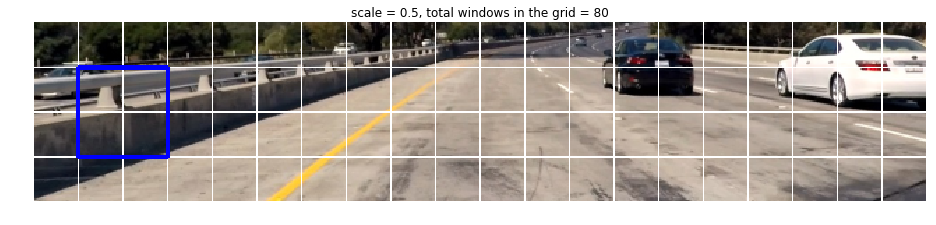

In [23]:
display_img_grid(undistort_images[0], SCALE_WINDOWS)

## Window Overlapping

total windows: 22


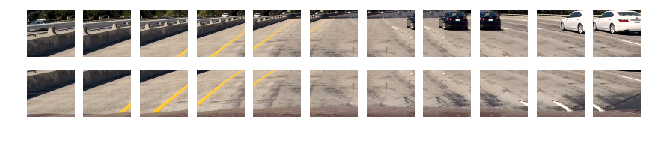

In [24]:
def display_windows_view(img, window_size=64, step_size=32):
    images, titles = [], []
    rows = (img.shape[0] - step_size) // step_size
    cols = (img.shape[1] - step_size) // step_size
    for y in range(0, img.shape[0] - window_size + 1, step_size):
        for x in range(0, img.shape[1] - window_size + 1, step_size):
            images.append(img[y:y + window_size, x:x + window_size])
            titles.append('')
    print('total windows:', rows * cols)
    display_images(rows, cols, images, titles, axis='off', figsize=(cols, rows))


img = cv2.cvtColor(undistort_images[0][400:], cv2.COLOR_BGR2RGB)
display_windows_view(cv2.resize(img, (0, 0), fx=0.3, fy=0.3))


In [25]:
def find_cars(img, scale_windows, window_size=64, step_size=32, PRINT=False):
    if PRINT: t = time.time()
    heatmap = np.zeros_like(img[:, :, 0])

    window_counter = 0
    nblocks_per_window = PIXELS_PER_CELL[0] - 1

    for scale in scale_windows:
        y_start = scale[0]
        y_stop = scale[1]
        scale_factor = scale[2]
        if PRINT: print('Search window: y_start =', y_start, 'y_stop =', y_stop, 'scale =', scale_factor)
        img_ycrcb = cv2.cvtColor(img[y_start:y_stop], cv2.COLOR_BGR2YCrCb)
        image = cv2.resize(img_ycrcb, (0, 0), fx=scale_factor, fy=scale_factor)
    
        hog1 = hog(image[:, :, 0], ORIENT, PIXELS_PER_CELL, CELLS_PER_BLOCK, feature_vector=False)
        hog2 = hog(image[:, :, 1], ORIENT, PIXELS_PER_CELL, CELLS_PER_BLOCK, feature_vector=False)
        hog3 = hog(image[:, :, 2], ORIENT, PIXELS_PER_CELL, CELLS_PER_BLOCK, feature_vector=False)
    
        win_map = int(window_size // scale_factor)
        for y in range(0, image.shape[0] - window_size + 1, step_size):
            yp = y // 8
            for x in range(0, image.shape[1] - window_size + 1, step_size):
                subimg = image[y:y + window_size, x:x + window_size]
                # Spatial features
                img_resized = cv2.resize(subimg, SPATIAL_SIZE)
                s0 = img_resized[:, :, 0].ravel()
                s1 = img_resized[:, :, 1].ravel()
                s2 = img_resized[:, :, 2].ravel()
    
                # Color histogram features
                c0 = np.histogram(subimg[:, :, 0], bins=HIST_BINS)[0]
                c1 = np.histogram(subimg[:, :, 1], bins=HIST_BINS)[0]
                c2 = np.histogram(subimg[:, :, 2], bins=HIST_BINS)[0]
    
                # Get hog features
                xp = x // 8
                h0 = hog1[yp:yp + nblocks_per_window, xp:xp + nblocks_per_window].ravel()
                h1 = hog2[yp:yp + nblocks_per_window, xp:xp + nblocks_per_window].ravel()
                h2 = hog3[yp:yp + nblocks_per_window, xp:xp + nblocks_per_window].ravel()
    
                features = scaler.transform(np.concatenate((s0, s1, s2, c0, c1, c2, h0, h1, h2)))
                test_features = scaler.transform(features)
    
                if svc.predict(test_features) == 1:
                    y_map = int(y // scale_factor)
                    x_map = int(x // scale_factor)
                    heatmap[y_map + y_start: y_map + y_start + win_map, x_map: x_map + win_map] += 1
                window_counter += 1

    if PRINT: print(time.time() - t, 'seconds to run, total windows = ', window_counter)
    return heatmap


hm = find_cars(undistort_images[0], SCALE_WINDOWS, PRINT=True)

Search window: y_start = 390 y_stop = 646 scale = 0.5
0.27254700660705566 seconds to run, total windows =  57


** New Scale Windows Setting**

In [26]:
SCALE_WINDOWS = [(390, 646, 0.5), (400, 592, 1.0), (400, 486, 1.5)]

In [27]:
def draw_labeled_boxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (255, 255, 0), 6)
    return img

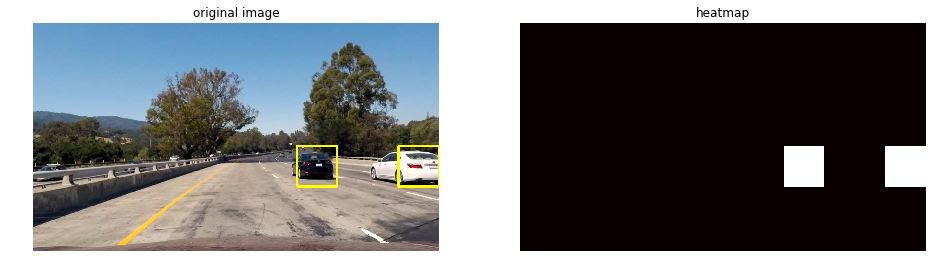

In [28]:
labels = label(hm)

img = cv2.cvtColor(np.copy(undistort_images[0]), cv2.COLOR_BGR2RGB)
draw_img = draw_labeled_boxes(img, labels)
display_images(1, 2, [draw_img, hm], ['original image', 'heatmap'])

20.7 minutes estimated time for video


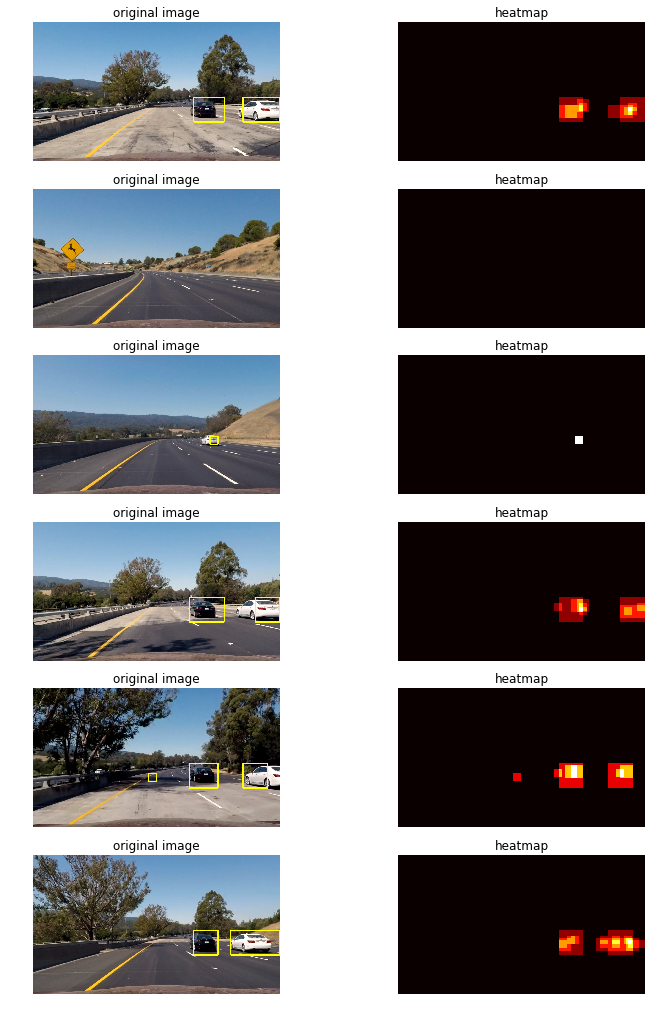

In [29]:

def apply_threhold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


out_images = []
out_maps = []
out_titles = []

t = time.time()
for i, img in enumerate(undistort_images):
    heat_map = find_cars(img, SCALE_WINDOWS)

    labels = label(heat_map)
    draw_img = draw_labeled_boxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)
    out_images.extend((draw_img, heat_map))
    out_titles.extend(('original image', 'heatmap'))

print(round((time.time() - t) / 6 * 21, 1), 'minutes estimated time for video')
display_images(8, 2, out_images, out_titles, axis='Off', figsize=(12, 24))

## Video Implementation

In [33]:
last_heatmaps = collections.deque(maxlen=25)


def process_image(img):
    global last_heatmaps
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    heat_map = find_cars(undist, SCALE_WINDOWS)
    last_heatmaps.append(heat_map)
    sum_heatmap = np.array(last_heatmaps).sum(axis=0)
    # threshold = min(len(last_heatmaps), 20)
    heat_map = apply_threhold(sum_heatmap, 18)
    labels = label(heat_map)
    draw_img = draw_labeled_boxes(np.copy(img), labels)
    map_image = sum_heatmap.astype(np.uint8) * 3
    gray_view = cv2.cvtColor(cv2.cvtColor(cv2.resize(np.copy(img), (360, 180)), cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    hm_view = cv2.cvtColor(cv2.resize(cv2.applyColorMap(map_image, cv2.COLORMAP_HOT), (360, 180)), cv2.COLOR_BGR2RGB)
    draw_img[0:180, 0:360] = cv2.addWeighted(gray_view, 0.5, hm_view, 0.5, 0.0)
    return draw_img

In [34]:
# input_video = './videos/test_video.mp4'
input_video = './videos/project_video_P4.mp4'
output_video = './videos/out_project_video.mp4'


In [35]:
clip = VideoFileClip(input_video)
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./videos/out_project_video.mp4
[MoviePy] Writing video ./videos/out_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [28:53<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos/out_project_video.mp4 



In [36]:
%%HTML
<video width="640" height="480" controls loop autoplay>
  <source src="./videos/out_test_video.mp4" type="video/mp4">
</video>